In [86]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn import svm
import pandas as pd
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import os

from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.metrics import roc_auc_score

In [2]:
is_vae = True
# Just choose the name of the dataset directory
DATA_DIR = '/Users/tomas/Documents/FEUP/Tese/data/ml-20m/processed_70_10_20'
if is_vae:
    PARSE_DATA_DIR = os.path.join(DATA_DIR, 'embeddings/vae')
    file = 'metadataset_k_20.csv'
else:
    PARSE_DATA_DIR = os.path.join(DATA_DIR, 'embeddings/cdae')
    file = '200_fac_metadataset_k_20.csv'
    #file = 'metadataset_k_20.csv'


In [61]:
#read in the data using pandas
metadataset = pd.read_csv(os.path.join(PARSE_DATA_DIR, file ))
#metadataset = metadataset[metadataset.first_place != 'zeroes']
metadataset.head()

,original_id,1,2,3,4,5,6,7,8,9,...,192,193,194,195,196,197,198,199,200,first_place
0,7648,-0.431028,0.273519,0.000467,-0.021366,0.411798,0.445795,1.206461,0.437548,-0.670044,...,1.261934,0.238986,0.150137,-0.024725,-0.349221,3.509393,-0.146421,1.508804,-0.859744,als_ndcg
1,10208,0.351687,-0.626017,0.034143,-0.080265,0.101129,-0.229498,0.261393,-1.189405,-0.451783,...,0.964082,0.825656,0.064932,0.042978,-1.043557,0.562128,0.234560,0.813003,0.511105,zeroes
2,13315,-0.706174,-0.031290,-0.005091,-0.097111,0.111871,0.484369,0.737223,-1.132764,1.119018,...,1.040254,-1.375516,-0.064951,0.030435,0.757224,0.444452,0.753969,-0.582505,0.761838,bpr_ndcg
3,16144,0.672244,-0.958536,-0.005133,-0.093083,0.118219,-0.325690,1.434977,0.006304,-0.780396,...,1.159395,-0.746610,0.042197,0.038217,-0.813577,1.753534,-0.063353,-0.829087,-1.122440,most_popular_ndcg
4,18064,-0.813108,0.897909,-0.105261,0.080410,0.099298,-1.109625,2.775797,0.139941,-0.745728,...,0.584199,0.619601,0.027197,0.051431,-1.668557,1.609979,-1.117613,1.222671,-2.145877,lmf_ndcg


### Encoder

In [62]:
#als:0
#bpr:1
#lmf:2
#most_pop_3
#zeros:4
target_pre = metadataset['first_place'].values 
label_encoder = LabelEncoder()
target = label_encoder.fit_transform(target_pre)

keys = label_encoder.classes_
values = label_encoder.transform(keys)
labels = dict(zip(values,keys))

### Normalization inputs

In [63]:
normalize = True

In [64]:
if normalize:
  #---- SET INPUTS -----
  scaler = StandardScaler()
  #Compute the mean and std to be used for later scaling.
  scaler.fit(metadataset.drop(columns=['first_place','original_id']))
  # Perform standardization by centering and scaling
  inputs_transform = scaler.transform(metadataset.drop(columns=['first_place','original_id']))
  inputs = pd.DataFrame(inputs_transform)
  inputs.head()
else:
  inputs = metadataset.drop(columns=['first_place','original_id'])

### Model

In [65]:
kf = KFold(n_splits=5)
kf.get_n_splits()
print(kf)

KFold(n_splits=5, random_state=None, shuffle=False)


In [66]:
is_smote = False

In [67]:
params ={'C': 316.22776601683796, 'penalty': 'l2', 'solver': 'lbfgs','random_state':0}


iteration:  1
fit


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   18.8s finished


starting base_level_eval
starting base_level_eval


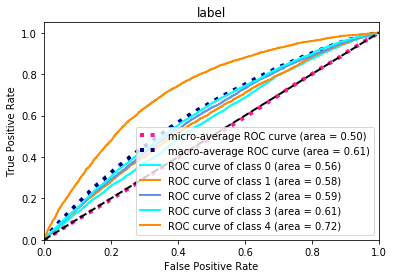

end:  4
iteration:  5
fit


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   20.0s finished


starting base_level_eval
starting base_level_eval


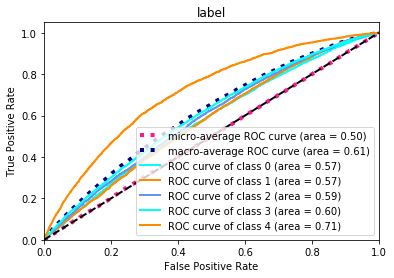

end:  4
iteration:  5
fit


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   21.9s finished


starting base_level_eval
starting base_level_eval


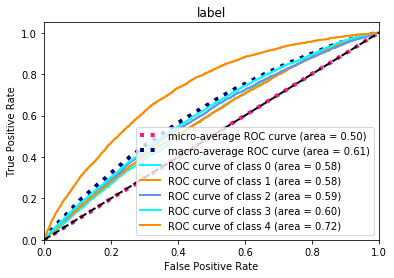

end:  4
iteration:  5
fit


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   20.9s finished


starting base_level_eval
starting base_level_eval


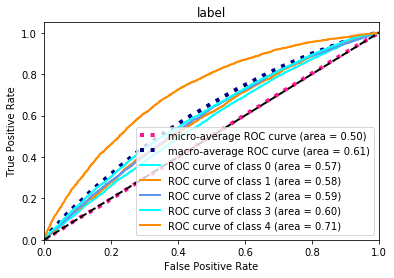

end:  4
iteration:  5
fit


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   21.2s finished


starting base_level_eval
starting base_level_eval


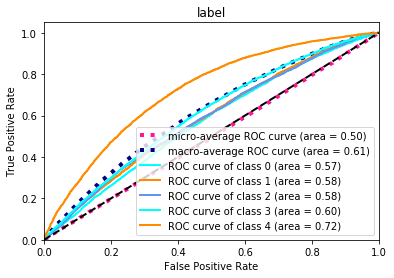

end:  4


In [99]:
i = 1 
bases = []
reports = []
base_impact_with_zeroes = []
base_impact_without_zeroes_most = []
base_impact_without_zeroes_best = []
matrix = []

base_impact_with_zeroes_without_true_zeroes = []
base_impact_without_zeroes_most_without_true_zeroes = []
base_impact_without_zeroes_best_without_true_zeroes = []

confusion_without_true_zeroes = []
reports_without_true_zeroes = []
n_classes = len(np.unique(metadataset['first_place'].values))
lw = 2
for train_index, test_index in kf.split(inputs):
    print('iteration: ', i)
    #get data fold
    X_train, X_test = inputs.iloc[train_index], inputs.iloc[test_index]
    y_train, y_test = target[train_index], target[test_index]
    
    #start model 
    print('fit')
    clf = LogisticRegression(
        penalty=params['penalty'], 
        C=params['C'],
        solver=params['solver'],
        random_state=params['random_state'],
        verbose=5,
        n_jobs=4)
    
    if is_smote:
        print('dataset shape %s' % Counter(y_train))
        sm = SMOTE(random_state=42)
        X_train_re, y_train_re = sm.fit_resample(X_train, y_train)
        print('Resampled dataset shape %s' % Counter(y_train_re))

        clf.fit(X_train_re, y_train_re)
        print('predict')
    else:
        clf.fit(X_train, y_train)
        
    y_pred = clf.predict(X_test)
    
    y_score = clf.decision_function(X_test)
    
    #Remove users that are zeroes 
    data = {'real':  y_test,
        'pred': y_pred,
        'original_id':metadataset.iloc[test_index]['original_id'].values
    }
    df = pd.DataFrame (data, columns = ['real','pred','original_id'])
    df = df[df.real != 4]
    
    # Compute ROC curve and ROC area for each class
    #fpr = dict()
    #tpr = dict()
    #roc_auc = dict()
    #all_test = []
    #for i in range(n_classes):
    #    test_ravel = np.where(df.real == i, 1, 0)
    #    all_test.append(test_ravel)
    #    fpr[i], tpr[i], _ = roc_curve(test_ravel, df.score[:, i])
    #    roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    #fpr["micro"], tpr["micro"], _ = roc_curve(np.ravel(all_test), df.score.ravel())
    #roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    #print_roc(fpr, tpr, roc_auc, 'no users with true zeroes')
    
    #wihtout zeroes users
    c_n_z = confusion_matrix(df.real,df.pred)
    r_n_z = classification_report(df.real,
                                    df.pred, 
                                   target_names=np.unique(metadataset['first_place'].values),
                                  output_dict=True,
                                 zero_division=1)
    
    bl_zeroes_n_z, bl_no_zeroes_most_n_z, bl_no_zeroes_best_n_z = base_level_eval(df.original_id,
             list(label_encoder.inverse_transform(df.pred)))

    base_impact_with_zeroes_without_true_zeroes.append(bl_zeroes_n_z)
    base_impact_without_zeroes_most_without_true_zeroes.append(bl_no_zeroes_most_n_z)
    base_impact_without_zeroes_best_without_true_zeroes.append(bl_no_zeroes_best_n_z)
    
    confusion_without_true_zeroes.append(c_n_z)
    reports_without_true_zeroes.append(r_n_z)
    
    #BASE LEVEL PERFORMANCE
    bl_zeroes, bl_no_zeroes_most, bl_no_zeroes_best = base_level_eval(metadataset.iloc[test_index]['original_id'].values,
             list(label_encoder.inverse_transform(y_pred)))

    base_impact_with_zeroes.append(bl_zeroes)
    base_impact_without_zeroes_most.append(bl_no_zeroes_most)
    base_impact_without_zeroes_best.append(bl_no_zeroes_best)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    all_test = []
    for i in range(n_classes):
        test_ravel = np.where(y_test == i, 1, 0)
        all_test.append(test_ravel)
        fpr[i], tpr[i], _ = roc_curve(test_ravel, y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(np.ravel(all_test), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    print_roc(fpr, tpr, roc_auc, 'all classes' )
    # ALL
    report = classification_report(y_test, 
                                   y_pred, 
                                   target_names=np.unique(metadataset['first_place'].values),
                                  output_dict=True)
    confusion = confusion_matrix(y_test,y_pred)
    matrix.append(confusion)
    np.set_printoptions(suppress=True)
   
    reports.append(report)
    print('end: ', i)
    i+=1

In [100]:
print('base level impact zeroes', np.mean(base_impact_with_zeroes))
print('base level impact  whithout zeroes, replaced most_pop', np.mean(base_impact_without_zeroes_most))
print('base level impact  whithout zeroes, replaced best', np.mean(base_impact_without_zeroes_best))
avg_reports = report_average(reports)
print_report(avg_reports)
print_confusion(np.mean( np.array(matrix),axis=0 ),labels)

base level impact zeroes 0.2367079550882988
base level impact  whithout zeroes, replaced most_pop 0.2589942317741318
base level impact  whithout zeroes, replaced best 0.2976851897159204
+-------------------+---------------------+----------------------+---------------------+
|     Algorithm     |      Precision      |        Recall        |          F1         |
+-------------------+---------------------+----------------------+---------------------+
|      als_ndcg     | 0.30118653702023523 |  0.5187436037029902  |  0.3810705055908249 |
|      bpr_ndcg     | 0.24799341846496997 | 0.16369488700429585  | 0.19713020302151146 |
|      lmf_ndcg     | 0.22260383720425908 | 0.010955594137912927 | 0.02086594721790599 |
| most_popular_ndcg |  0.3020246307570151 |  0.3015956444531426  |  0.3017581221723364 |
|       zeroes      |  0.3369190493953086 |  0.3755013849651598  | 0.35512206436258853 |
|        ---        |         ---         |         ---          |         ---         |
|     macro a

In [101]:
print('base level impact zeroes', np.mean(base_impact_with_zeroes_without_true_zeroes))
print('base level impact  whithout zeroes, replaced most_pop', np.mean(base_impact_without_zeroes_most_without_true_zeroes))
print('base level impact  whithout zeroes, replaced best', np.mean(base_impact_without_zeroes_best_without_true_zeroes))

avg_reports = report_average(reports_without_true_zeroes)
print_report(avg_reports)
print_confusion(np.mean( np.array(confusion_without_true_zeroes),axis=0 ),labels)

base level impact zeroes 0.28313501953878345
base level impact  whithout zeroes, replaced most_pop 0.3097929920341931
base level impact  whithout zeroes, replaced best 0.3560731228836943
+-------------------+---------------------+----------------------+----------------------+
|     Algorithm     |      Precision      |        Recall        |          F1          |
+-------------------+---------------------+----------------------+----------------------+
|      als_ndcg     |  0.3425307801833555 |  0.5187436037029902  |  0.4125728441388679  |
|      bpr_ndcg     |  0.2984346532200298 | 0.16369488700429585  | 0.21134667162601986  |
|      lmf_ndcg     |  0.2325989160211713 | 0.010955594137912927 | 0.020910298439181397 |
| most_popular_ndcg | 0.33984863951351335 |  0.3015956444531426  | 0.31954025506069017  |
|       zeroes      |         0.0         |         1.0          |         0.0          |
|        ---        |         ---         |         ---          |         ---          |
|  

#### Prints function

In [94]:
def print_roc(fpr, tpr, roc_auc, label):
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('label')
    plt.legend(loc="lower right")
    plt.show()
    return

In [95]:
def print_confusion(values, classes):
    from prettytable import PrettyTable
    x = PrettyTable()
    print(classes)

    names = []
    names.append('algorithm')
    names = names + list(classes.values())

    x.field_names = names

    i = 0
    for row in values:
        #row = np.array(row)
        r = []
        r.append(classes[i])
        row = r + list(row)
        #r.append(classes[i])
        #r = r + row
        #row = np.insert(row,0,'als')
        x.add_row(row)
        #r  = np.concatenate(csses[i],row[])
        i +=1
    print(x)

In [96]:
def report_average(reports):
    mean_dict = dict()
    for label in reports[0].keys():
        dictionary = dict()

        if label in 'accuracy':
            mean_dict[label] = sum(d[label] for d in reports) / len(reports)
            continue

        for key in reports[0][label].keys():
            dictionary[key] = sum(d[label][key] for d in reports) / len(reports)
        mean_dict[label] = dictionary

    return mean_dict

In [97]:
def print_report(avg_reports):
    from prettytable import PrettyTable
    x = PrettyTable()

    x.field_names = ["Algorithm", "Precision", "Recall", "F1"]

    for label in avg_reports.keys():
        if label in 'accuracy':
            x.add_row(['---','---','---','---'])
            continue
        x.add_row([label, 
                   avg_reports[label]['precision'], 
                   avg_reports[label]['recall'], 
                   avg_reports[label]['f1-score']])


    print(x)
    print('Accuracy: ', avg_reports['accuracy'])

In [98]:
def base_level_eval(users, predictions):
    """Uses the predctions to return the average of the ndcg impact at base level.
    Args:
        users: list of users ids
        predictions:predictions for users. PREDS HAVE TO be the same index ahas the users list
    Returns:
        average of ndcg
    """
    print('starting base_level_eval')
    results_algo = pd.read_csv(os.path.join(DATA_DIR, 'results_metadataset.csv'))
    base_impact = []
    base_impact_zeroes_most = []
    base_impact_zeroes_best = []
    for user_uid, pred in zip(users, predictions):


        val = results_algo.loc[ results_algo['original_id'] == user_uid, pred ]
        if pred == 'zeroes':
            val_zeroes = results_algo.loc[ results_algo['original_id'] == user_uid, 'most_popular_ndcg']
            best = results_algo.loc[ results_algo['original_id'] == user_uid]

            base_impact.append(val.values[0])
            base_impact_zeroes_most.append(val_zeroes.values[0])
            base_impact_zeroes_best.append(best.drop('original_id', 1).max(axis=1).values[0])
        else:
            base_impact.append(val.values[0])
            base_impact_zeroes_most.append(val.values[0])
            base_impact_zeroes_best.append(val.values[0])


        if len(val.values) > 1:
            raise Exception("More than one case")

    return np.mean(base_impact), np.mean(base_impact_zeroes_most), np.mean(base_impact_zeroes_best)


## Gridsearch

In [45]:
grid={
    "C":np.logspace(-5,5,9), 
    "penalty":["l2"],
    "solver":["newton-cg", "lbfgs", "liblinear", "sag", "saga"]
}# l1 lasso l2 ridge

logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=5, verbose=10, n_jobs=-1)
logreg_cv.fit(inputs,target)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   53.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 21.9min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 33.5min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 34.6min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 49.0min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 54.0min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 70.1min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 86.2min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 95.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 121.0min
/usr/local/lib/python3.7/site-packages/joblib/externals

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': array([1.00000000e-05, 1.77827941e-04, 3.16227766e-03, 5.62341325e-02,
       1.00000000e+00, 1.77827941e+01, 3.16227766e+02, 5.62341325e+03,
       1.00000000e+05]),
                         'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                          

In [46]:
logreg_cv.best_params_

{'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}

In [104]:
logreg_cv.best_params_

{'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}

In [25]:
grid

{'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 'penalty': ['l2'],
 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}